Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!
train_x's shape: (11272, 784)
test_x's shape: (1866, 784)
loop: 0 0.7043777293828246
loop: 100 0.3094035952916154
loop: 200 0.19106252178519784
loop: 300 0.15772416545553872
loop: 400 0.14255528361091024
loop: 500 0.1336554274346174
loop: 600 0.12762011895982686
loop: 700 0.12313725586696012
loop: 800 0.11959735791192314
loop: 900 0.11667822443364367
loop: 999 0.11421530024777592
Accuracy: 0.9599893541518808
Accuracy: 0.9598070739549842


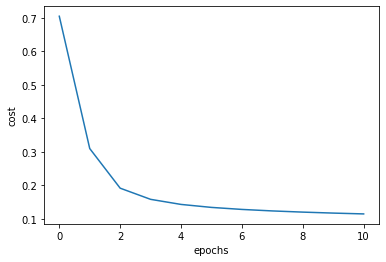

In [2]:
# 역전파법
import matplotlib.pylab as plt
import scratch.dataset.mnist as mnist
import numpy as np


class ANN:
    def __init__(self, layers_size):
        self.layers_size = layers_size
        self.parameters = {}
        self.L = len(self.layers_size)
        self.n = 0
        self.costs = []

    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))

    def initialize_parameters(self):
        np.random.seed(1)

        for l in range(1, len(self.layers_size)):
            self.parameters["W" + str(l)] = np.random.randn(self.layers_size[l], self.layers_size[l - 1]) / np.sqrt(
                self.layers_size[l - 1])
            self.parameters["b" + str(l)] = np.zeros((self.layers_size[l], 1))

    def forward(self, X):
        store = {}
        A = X.T

        for l in range(self.L - 1):
            Z = self.parameters["W" + str(l + 1)].dot(A) + self.parameters["b" + str(l + 1)]
            A = self.sigmoid(Z)
            store["A" + str(l + 1)] = A
            store["W" + str(l + 1)] = self.parameters["W" + str(l + 1)]
            store["Z" + str(l + 1)] = Z

        Z = self.parameters["W" + str(self.L)].dot(A) + self.parameters["b" + str(self.L)]
        A = self.sigmoid(Z)
        store["A" + str(self.L)] = A
        store["W" + str(self.L)] = self.parameters["W" + str(self.L)]
        store["Z" + str(self.L)] = Z

        return A, store

    def sigmoid_derivative(self, Z):
        s = 1 / (1 + np.exp(-Z))
        return s * (1 - s)

    def backward(self, X, Y, store):
        derivatives = {}
        store["A0"] = X.T

        A = store["A" + str(self.L)]
        dA = -np.divide(Y, A) + np.divide(1 - Y, 1 - A)

        dZ = dA * self.sigmoid_derivative(store["Z" + str(self.L)])
        dW = dZ.dot(store["A" + str(self.L - 1)].T) / self.n
        db = np.sum(dZ, axis=1, keepdims=True) / self.n
        dAPrev = store["W" + str(self.L)].T.dot(dZ)

        derivatives["dW" + str(self.L)] = dW
        derivatives["db" + str(self.L)] = db

        for l in range(self.L - 1, 0, -1):
            dZ = dAPrev * self.sigmoid_derivative(store["Z" + str(l)])
            dW = 1. / self.n * dZ.dot(store["A" + str(l - 1)].T)
            db = 1. / self.n * np.sum(dZ, axis=1, keepdims=True)
            if l > 1:
                dAPrev = store["W" + str(l)].T.dot(dZ)

            derivatives["dW" + str(l)] = dW
            derivatives["db" + str(l)] = db

        return derivatives

    def fit(self, X, Y, learning_rate=0.01, n_iterations=2500):
        np.random.seed(1)
        self.n = X.shape[0]
        self.layers_size.insert(0, X.shape[1])
        self.initialize_parameters()

        for loop in range(n_iterations):
            A, store = self.forward(X)
            cost = np.squeeze(-(Y.dot(np.log(A.T)) + (1 - Y).dot(np.log(1 - A.T))) / self.n) # 손실함수
            derivatives = self.backward(X, Y, store)

            for l in range(1, self.L + 1):
                self.parameters["W" + str(l)] = self.parameters["W" + str(l)] - learning_rate * derivatives[
                    "dW" + str(l)]
                self.parameters["b" + str(l)] = self.parameters["b" + str(l)] - learning_rate * derivatives[
                    "db" + str(l)]

            if loop % 100 == 0:
                print("loop:", loop, cost)
                self.costs.append(cost)
        print("loop:", loop, cost)
        self.costs.append(cost)

    def predict(self, X, Y):
        A, cache = self.forward(X)
        n = X.shape[0]
        p = np.zeros((1, n))

        for i in range(0, A.shape[1]):
            if A[0, i] > 0.5:
                p[0, i] = 1
            else:
                p[0, i] = 0

        print("Accuracy: " + str(np.sum((p == Y) / n)))

    def plot_cost(self):
        plt.figure()
        plt.plot(np.arange(len(self.costs)), self.costs)
        plt.xlabel("epochs")
        plt.ylabel("cost")
        plt.show()


def get_binary_dataset():
    (train_x_orig, train_y_orig), (test_x_orig, test_y_orig) = mnist.load_mnist(normalize=True, flatten=True, one_hot_label=False)

    index_5 = np.where(train_y_orig == 5)
    index_8 = np.where(train_y_orig == 8)

    index = np.concatenate([index_5[0], index_8[0]])
    np.random.seed(1)
    np.random.shuffle(index)

    train_y = train_y_orig[index]
    train_x = train_x_orig[index]

    train_y[np.where(train_y == 5)] = 0
    train_y[np.where(train_y == 8)] = 1

    index_5 = np.where(test_y_orig == 5)
    index_8 = np.where(test_y_orig == 8)

    index = np.concatenate([index_5[0], index_8[0]])
    np.random.shuffle(index)

    test_y = test_y_orig[index]
    test_x = test_x_orig[index]

    test_y[np.where(test_y == 5)] = 0
    test_y[np.where(test_y == 8)] = 1

    return train_x, train_y, test_x, test_y


if __name__ == '__main__':
    train_x, train_y, test_x, test_y = get_binary_dataset() # mnist 데이터셋을 불러와 Train set과 Test set으로 나눈다. 숫자 5를 Class 0, 숫자 8을 Class 1로 하여 이진분류 문제를 풀기로 한다.

    print("train_x's shape: " + str(train_x.shape)) # (11272, 784)
    print("test_x's shape: " + str(test_x.shape)) # (1866, 784)

    layers_dims = [196, 1] # 히든 레이어의 노드는 196개

    ann = ANN(layers_dims)
    ann.fit(train_x, train_y, learning_rate=0.1, n_iterations=1000)
    ann.predict(train_x, train_y)
    ann.predict(test_x, test_y)
    ann.plot_cost()


# Keras로 살펴보는 ANN
본격적으로 인공신경망(Artificial Neural Network) 를 공부하기에 앞서 딥러닝 라이브러리 중 하나인 Keras를 활용하여 뉴럴 네트워크의 전반적인 구조를 먼저 학습해보는 시간을 갖겠습니다.

http://cs231n.github.io/assets/nn1/neural_net.jpeg

뉴럴 네트워크는 여러 노드들이 수많은 layer로 구성되어 마치 사람 뇌의 뉴런처럼 데이터를 전송하고 값을 갱신해나가는 구조를 가지고 있습니다. 뉴럴 네트워크의 진행 과정은 크게 다음과 같습니다 :

* 데이터 불러오기 및 가공
* 뉴럴넷에 필요한 파라메터 세팅
* Training
* Test
* 시각화

구체적인 실습을 통해 뉴럴 네트워크에 좀 더 친숙해져 봅시다.

### 실습
코드의 흐름을 따라가면서 Neural Network가 어떻게 동작하는 지 살펴보세요.

train_image의 shape를 출력해 보세요.

train_labels의 데이터 개수를 출력해 보세요.

train_labels를 출력해 보세요.

test_image의 shape를 출력해 보세요.

test_labels의 데이터 개수를 출력해 보세요.

In [1]:

# tensorflow와 tf.keras를 임포트합니다
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

def main():

    # Fashion mnist data 를 load 합니다.
    fashion_mnist = keras.datasets.fashion_mnist
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

    train_images = train_images / 255.0
    test_images = test_images / 255.0

    # label에 해당하는 class name 입니다.
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


    # 2-layer 모델을 생성합니다.
    model = keras.Sequential([
        # x data가 2차원인 것을 1차원으로 변경해줍니다.
        keras.layers.Flatten(input_shape=(28, 28)),
        # 첫번째 layer의 뉴런 개수를 정합니다.
        keras.layers.Dense(128, activation=tf.nn.relu),
        # 두번째 layer의 뉴런 개수를 정합니다. (output)
        keras.layers.Dense(10, activation=tf.nn.softmax)
    ])

    # 모델의 상세 기법을 정의합니다.
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # 모델을 train image, train label을 가지고 학습시킵니다.
    model.fit(train_images, train_labels, epochs=5)


    # 모델의 loss와 accuracy를 계산합니다.
    test_loss, test_acc = model.evaluate(test_images, test_labels)

    print('\n- TEST 정확도 :', test_acc)


    # 학습한 모델로 테스트 데이터를 예측합니다.
    predictions = model.predict(test_images)


    # 2. train_image의 shape를 출력해 보세요.
    print("\n- train image shape : \n",train_images.shape)
    
    # 3. train_labels의 데이터 개수를 출력해 보세요.
    print("\n- train labels length : \n", len(train_labels))
    
    # 4. train_labels를 출력해 보세요.
    print("\n- train labels : \n", train_labels)
    
    # 5. test_image의 shape를 출력해 보세요.
    print("\n- test image shape : \n", test_images.shape)
    
    # 6. test_labels의 데이터 개수를 출력해 보세요.
    print("\n- test labels length : \n", len(test_labels))
    print()
    

    # test_images의 0번째 data를 제대로 맞췄는지 확인해봅니다.
    i = 0
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plot_image(i, predictions, test_labels, test_images, class_names)
    plt.subplot(1,2,2)
    plot_value_array(i, predictions,  test_labels)
#     plt.savefig('ANN.png')

    # test_images의 12번째 data를 제대로 맞췄는지 확인해봅니다.
    i = 12
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plot_image(i, predictions, test_labels, test_images, class_names)
    plt.subplot(1,2,2)
    plot_value_array(i, predictions,  test_labels)
#     plt.savefig('ANN.png')


def plot_image(i, predictions_array, true_label, img, class_names):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% (true:{})".format(class_names[predicted_label],
                                    100*np.max(predictions_array),
                                    class_names[true_label]),
                                    color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')


if __name__ == "__main__":
    main()

ModuleNotFoundError: No module named 'matplotlib.pyplot'

# 인공신경망 모델 설계하기
하나의 Layer에 대한 연산은 각각의 입력 값(input)과 가중치(weight) 값들의 곱과 전체의 합, 그리고 activation function을 통과하여 비선형의 결과값으로 나타납니다.

http://cs231n.github.io/assets/nn1/neuron_model.jpeg
    
이렇게 모델링을 하는 이유는, 입력값 (X, y)(X,y) 가 주어져 있을 때, 복잡한 문제를 선형 함수 y = WX + by=WX+b 와 비선형 함수 (sigmoid function, etc) 로 모델링을 하여, 실제 원하는 가중치(WW)를 뽑아내기 위함입니다.

원래는 어떠한 현상을 모델링 하려면 사람이 수학적으로 복잡한 함수를 미리 선정하고, 현재 가지고 있는 입력값을 대입해서, 그에 맞는 가중치(WW)를 판단해야 하는데요. 입력값에 맞는 함수를 선정하는 것은 비용이 많이 들고, 매우 어려운 일입니다.

인공신경망에서 선형 함수와 비선형 함수의 간단한 조합으로 사람이 Layer 층의 수, Layer 당 Node 개수, 학습 속도 등등의 파라미터만 조정해준다면,

컴퓨터가 알아서 최적화 된 가중치(WW)를 판단해주고, 이로써 정확도가 굉장히 높은 모델을 만들어 낼 수 있습니다.

이번 실습에서는 [실습 13-1]과 마찬가지로 Fashion Mnist data set을 가지고 직접 2층 짜리 뉴럴 네트워크 모델을 구축해 보겠습니다.

### 실습
Line 101 의 neural_net() 함수를 채워가며 직접 모델을 설계해 보겠습니다.

layer을 완성하려면 다음과 같은 절차가 필요합니다.

* 입력인자 x, weights, biases가 Line 58, 63의 dictionary 형태이니, 여기서 값을 하나씩 추출해서 사용하세요.
* y = WX+by=WX+b 의 수식으로 하나의 layer가 완성됩니다.
* 여기에 sigmoid function을 씌워 비선형으로 만들어 줍니다.

#### 아래 함수들을 이용해서 layer1, layer2, out layer, 총 3개의 layer를 완성해 보세요.

(out layer는 sigmoid function을 씌우지 않습니다. 왜냐하면 마지막에 softmax function을 적용하기 때문입니다.)

#### 사용 될 tensorflow 함수

* tf.add(a,b) : a와 b를 더합니다.
* tf.matmul(a,b) : a와 b의 행렬곱을 합니다.
* tf.nn.sigmoid(a) : a에 sigmoid 연산을 적용합니다.

In [ ]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt


def main():
    
    # Fasion mnist data를 불러옵니다.
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    
    
    # y에 해당하는 전체 클래스 개수를 의미합니다.
    num_classes = 10
    
    # y에 해당하는 class name 입니다.
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
    # image shape : 28*28 = data features
    num_features = 784

    # 1st layer 뉴런의 개수를 설정합니다.
    hidden_layer_1 = 64
    
    # 2nd layer 뉴런의 개수를 설정합니다.
    hidden_layer_2 = 128

    # Training 을 위한 파라메터입니다.
    learning_rate = 0.05
    training_steps = 3000
    batch_size = 512
    interval = 300


    # Training data를 float32 자료형으로 형변환 해줍니다.
    x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
    
    # 2차원 이미지를 1차원으로 변형합니다.
    x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
    
    # 값을 [0, 255] 에서 [0, 1]으로 정규화 해줍니다.
    x_train, x_test = x_train / 255., x_test / 255.

    # training data를 무작위로 선정하고, batch_size만큼 나눠주면서 초기화를 진행합니다.
    train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_data = train_data.repeat().shuffle(10000).batch(batch_size).prefetch(1)


    # weight 값들을 무작위로 초기화합니다.
    random_normal = tf.initializers.RandomNormal()

    # 각 layer에 들어갈 Weight, bias들을 할당해 줍니다.
    weights = {
        'h1': tf.Variable(random_normal([num_features, hidden_layer_1])),
        'h2': tf.Variable(random_normal([hidden_layer_1, hidden_layer_2])),
        'out': tf.Variable(random_normal([hidden_layer_2, num_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.zeros([hidden_layer_1])),
        'b2': tf.Variable(tf.zeros([hidden_layer_2])),
        'out': tf.Variable(tf.zeros([num_classes]))
    }


    # Training을 실제로 구현하는 부분입니다.
    for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
        # W 와 b 파라메터를 갱신하기 위해 함수를 호출합니다.
        params_optimization(batch_x, batch_y, weights, biases, num_classes, learning_rate)

        if step % interval == 0:
            '''
            neural_net() 함수는 model 생성에 사용되는 함수입니다.
            neural_net() 함수를 채워 pred를 완성해보도록 하겠습니다.
            '''
            pred = neural_net(batch_x, weights, biases)
            
            loss = cross_entropy(pred, batch_y, num_classes)
            acc = accuracy(pred, batch_y)
            print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))


    # Test를 진행하여 실제 정확도를 확인합니다.
    pred = neural_net(x_test, weights, biases)
    print("Test Accuracy: %f" % accuracy(pred, y_test))
    
    
    # 결과를 시각화합니다.
    plot_neural_network_results(pred, x_test, y_test, class_names)


    
# 인공 신경망 함수입니다.
'''
def neural_net(x, weights, biases) 함수를 채워보세요.
'''
def neural_net(x, weights, biases):
    
    # 총 2개의 layer로 이뤄져 있으며, fully connected 연산 후 sigmoid 함수에 적용하여 값을 비선형으로 만들어줍니다.
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.sigmoid(layer_1)
    
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.sigmoid(layer_2)
    
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    
    return tf.nn.softmax(out_layer)


# Cross-Entropy loss function에 대한 함수입니다.
def cross_entropy(y_pred, y_true, num_classes):

    y_true = tf.one_hot(y_true, depth=num_classes)
    
    # 값 중에 min 값이 1e-8, max 값이 1.0 이 넘어가는 값이 없도록 바운더리를 지정합니다.
    y_pred = tf.clip_by_value(y_pred, 1e-8, 1.)
    
    # cross-entropy를 수식으로 입력해 보세요.
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))


# 정확도(accuracy) 를 측정하는 함수입니다.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)


# 파라메터들을 갱신하는 함수입니다. 
def params_optimization(x, y, weights, biases, num_classes, learning_rate):
    # GradientTape() 함수를 묶어서 gradient를 자동 계산하도록 돕습니다.
    with tf.GradientTape() as gt:
        pred = neural_net(x, weights, biases)
        loss = cross_entropy(pred, y, num_classes)
        
    # variable을 업데이트합니다.
    variables_to_update = list(weights.values()) + list(biases.values())

    # gradient를 계산합니다.
    gradients = gt.gradient(loss, variables_to_update)
    
    # 파라메터(weight)들을 갱신하기 위한 함수를 지정해줍니다.
    optimizer = tf.optimizers.Adagrad(learning_rate)
    
    # optimizer로 W와 b를 갱신합니다.
    optimizer.apply_gradients(zip(gradients, variables_to_update))
    

def plot_neural_network_results(pred, x_test, y_test, class_names):
    # 결과를 시각화 하는 함수입니다.
    n_images = 10
    test_images = x_test[:n_images]
    predictions = pred

    plt.figure(figsize=(7,10))
    for i in range(n_images):
        plt.subplot(5,2,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(np.reshape(test_images[i], [28, 28]), cmap=plt.cm.binary)
        plt.xlabel("True : {} (Predict : {})".format(class_names[y_test[i]],
                                    class_names[np.argmax(predictions.numpy()[i])]))
#     plt.savefig('ANN.png')

    
if __name__ == "__main__":
    main()

# Loss function 구현해보기
분류 문제에서 정답 y_{true}ytrue 와 예측값 y_{pred}ypred 사이에 오차를 판별하기 위해서는 어떤 Loss function을 사용할까요?

회귀 문제에서는 Mean Squared Error가 오차 판별에 적합했다면, 분류 문제에서는 Cross entropy 함수가 오차를 판별하는 loss function으로 사용되고 있습니다.

(링크 참조 - 분류 오차에 Cross entropy를 사용하는 이유)

http://funmv2013.blogspot.com/2017/01/cross-entropy.html

H_{p, q}(X) = - \sum_{i=1}^{N} p(x_{i}) log q(x_{i}) H p,q	 (X)=− i=1∑N p(x i )logq(x i )

Cross entropy는 두 개의 확률 분포 p, qp,q에 대해 하나의 사건 XX 가 갖는 정보량 입니다. 다시 말해서, 서로 다른 두 확률 분포에 대해 같은 사건이 가지는 정보량을 계산한 것입니다. 이는 qq 에 대한 정보량을 pp 에 대해서 평균을 낸 것으로 볼 수 있습니다.

구체적인 실습을 통해 Cross entropy에 좀 더 친숙해져 봅시다.

### 실습
* Line 101의 neural_net()함수를 완성시켜보세요.

* Line 120 의 cross_entropy() 함수를 채워가며 직접 loss function을 구현해 보겠습니다.

Cross entropy loss function 은 다음과 같습니다.

H(y_{true}, y_{pred}) = - \frac {1}{N} \sum_{i=1}^{N} y_{true_i} log(y_{pred_i}) H(y true ,y pred )=− N1i=1∑N y true i log(y pred i )

아래 함수들을 이용해서 cross entropy 를 완성해 보세요.

### 사용 될 tensorflow 함수

* tf.reduce_mean(x) : x값에 대해 전체 평균을 구합니다.
* tf.reduce_sum(x) : x값에 대해 전체 덧셈을 합니다.
* tf.math.log(x) : x에 log 연산을 적용합니다.


In [4]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt


def main():
    
    # Fasion mnist data를 불러옵니다.
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    
    
    # y에 해당하는 전체 클래스 개수를 의미합니다.
    num_classes = 10
    
    # y에 해당하는 class name 입니다.
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
    # image shape : 28*28 = data features
    num_features = 784

    # 1st layer 뉴런의 개수를 설정합니다.
    hidden_layer_1 = 64
    
    # 2nd layer 뉴런의 개수를 설정합니다.
    hidden_layer_2 = 128

    # Training 을 위한 파라메터입니다.
    learning_rate = 0.05
    training_steps = 3000
    batch_size = 512
    interval = 300


    # Training data를 float32 자료형으로 형변환 해줍니다.
    x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
    
    # 2차원 이미지를 1차원으로 변형합니다.
    x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
    
    # 값을 [0, 255] 에서 [0, 1]으로 정규화 해줍니다.
    x_train, x_test = x_train / 255., x_test / 255.

    # training data를 무작위로 선정하고, batch_size만큼 나눠주면서 초기화를 진행합니다.
    train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_data = train_data.repeat().shuffle(10000).batch(batch_size).prefetch(1)


    # weight 값들을 무작위로 초기화합니다.
    random_normal = tf.initializers.RandomNormal()

    # 각 layer에 들어갈 Weight, bias들을 할당해 줍니다.
    weights = {
        'h1': tf.Variable(random_normal([num_features, hidden_layer_1])),
        'h2': tf.Variable(random_normal([hidden_layer_1, hidden_layer_2])),
        'out': tf.Variable(random_normal([hidden_layer_2, num_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.zeros([hidden_layer_1])),
        'b2': tf.Variable(tf.zeros([hidden_layer_2])),
        'out': tf.Variable(tf.zeros([num_classes]))
    }


    # Training을 실제로 구현하는 부분입니다.
    for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
        # W 와 b 파라메터를 갱신하기 위해 함수를 호출합니다.
        params_optimization(batch_x, batch_y, weights, biases, num_classes, learning_rate)

        if step % interval == 0:
            pred = neural_net(batch_x, weights, biases)
            '''
            cross_entropy() 함수는 loss function입니다.
            cross_entropy() 함수를 채워 loss 값을 완성해보도록 하겠습니다.
            '''
            loss = cross_entropy(pred, batch_y, num_classes)
            
            acc = accuracy(pred, batch_y)
            print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))


    # Test를 진행하여 실제 정확도를 확인합니다.
    pred = neural_net(x_test, weights, biases)
    print("Test Accuracy: %f" % accuracy(pred, y_test))
    
    
    # 결과를 시각화합니다.
    plot_neural_network_results(pred, x_test, y_test, class_names)


    
# 인공 신경망 함수입니다.
'''
def neural_net(x, weights, biases) 함수를 채워보세요.
'''
def neural_net(x, weights, biases):
    
    # 총 2개의 layer로 이뤄져 있으며, fully connected 연산 후 sigmoid 함수에 적용하여 값을 비선형으로 만들어줍니다.
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.sigmoid(layer_1)
    
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.sigmoid(layer_2)
    
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    
    return tf.nn.softmax(out_layer)


# Cross-Entropy loss function에 대한 함수입니다.
'''
def cross_entropy(y_pred, y_true, num_classes) 함수를 채워보세요.
'''
def cross_entropy(y_pred, y_true, num_classes):

    y_true = tf.one_hot(y_true, depth=num_classes)
    
    # 값 중에 min 값이 1e-8, max 값이 1.0 이 넘어가는 값이 없도록 바운더리를 지정합니다.
    y_pred = tf.clip_by_value(y_pred, 1e-8, 1.)
    N = y_pred.shape[0]
    # cross-entropy를 수식으로 입력해 보세요.
    return -tf.reduce_mean((tf.reduce_sum(y_true * tf.math.log(y_pred))))

# 정확도(accuracy) 를 측정하는 함수입니다.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)


# 파라메터들을 갱신하는 함수입니다. 
def params_optimization(x, y, weights, biases, num_classes, learning_rate):
    # GradientTape() 함수를 묶어서 gradient를 자동 계산하도록 돕습니다.
    with tf.GradientTape() as gt:
        pred = neural_net(x, weights, biases)
        loss = cross_entropy(pred, y, num_classes)
        
    # variable을 업데이트합니다.
    variables_to_update = list(weights.values()) + list(biases.values())

    # gradient를 계산합니다.
    gradients = gt.gradient(loss, variables_to_update)
    
    # 파라메터(weight)들을 갱신하기 위한 함수를 지정해줍니다.
    optimizer = tf.optimizers.Adagrad(learning_rate)
    
    # optimizer로 W와 b를 갱신합니다.
    optimizer.apply_gradients(zip(gradients, variables_to_update))
    

def plot_neural_network_results(pred, x_test, y_test, class_names):
    # 결과를 시각화 하는 함수입니다.
    n_images = 10
    test_images = x_test[:n_images]
    predictions = pred

    plt.figure(figsize=(7,10))
    for i in range(n_images):
        plt.subplot(5,2,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(np.reshape(test_images[i], [28, 28]), cmap=plt.cm.binary)
        plt.xlabel("True : {} (Predict : {})".format(class_names[y_test[i]],
                                    class_names[np.argmax(predictions.numpy()[i])]))
#     plt.savefig('ANN.png')
    
    
if __name__ == "__main__":
    main()

ModuleNotFoundError: No module named 'tensorflow.keras'

# Back propagation 개념 학습
인공신경망은 수많은 노드와 가중치(weight)들을 합하고, 비선형 함수를 계산하여 나타내는 모델입니다. 이 때, loss function에 모델을 적용했을 때 loss function 자체가 convex 하지 않게 되어 global minimum 값을 찾을 수가 없습니다.

https://static.thinkingandcomputing.com/2014/03/bprop.png

non-convex한 함수에 대한 minimum을 찾기 위해, 점진적으로 하강하면서 근방에 local minimum에 접근하는 방법이 있는데요. 이 때 활용되는 것이 gradient descent와 같은 방법입니다.

Back propagation은 loss function에서 각 가중치(weights)에 대해 미분을 진행하여, 그 미분값의 반대방향으로 gradient descent를 하기 위해 사용되는 기법입니다. 가중치의 미분값은 결과인 loss function에 대한 기울기이자, 1만큼 증가할 때의 변화량을 의미합니다.

Back propagation을 위해서 Chain rule 방법으로 복잡한 미분을 간단하게 계산합니다.

-------------------------
Chain rule 공식

https://www.onlinemathlearning.com/image-files/chain-rule.png

구체적인 실습을 통해 Back propagation 에 대해 알아봅시다.

### 실습
Chain rule 을 활용하여 직접

f(x,y,z) = (x + y) * zf(x,y,z)=(x+y)∗z

에 대한 x, y, zx,y,z 의 미분값을 구해봅시다.


df/dx
​	 , 
df/dy
​	 , 
df/dz
​	 

원래 함수를 다음 함수로 잘게 쪼개어 각 미분값을 구해보세요.

f = h * zf=h∗z
h = x + yh=x+y

In [5]:

def main():
	# Input 값을 다음과 같이 할당합니다.
    x = -7; y = 3; z = 5

    # Forward propatation 은 차례로 모델의 값을 입력하는 방식입니다.
    # f = (x + y) * z 를 다음과 같이 각 재정의를 통해서 선언합니다.
    h = x + y
    f = h * z

    # 거꾸로 Back propagation을 진행해봅시다:
    # 첫번째 미분 대상은 f = h * z 입니다.
    dfdh = z
    dfdz = h

    # 다음 미분 대상은 h = x + y 입니다.
    dhdx = 1
    dhdy = 1

    # Chain rule 을 적용하여 값을 구해보세요.
    dfdx = dfdh * dhdx
    dfdy = dfdh * dhdy
    
    print (dfdx,dfdy,dfdz)

    if(dfdx == 5 and dfdy == 5 and dfdz == -4):
        print("답 : 정답입니다.")
    else:
        print("답 : 입력값을 다시 넣어 보세요.")

if __name__ == "__main__":
    main()


5 5 -4
답 : 정답입니다.


# Sigmoid back propagation 연산 구현
Sigmoid 함수에 x값을 입력하면, 결과 값이 0과 1사이로 리턴 됩니다. 이는 인공신경망에서 선형 결합인 WX + bWX+b 값을 0과 1사이로 변환하여 비선형으로 만들어서 분류 문제를 쉽게 풀 수 있도록 도와줍니다.

https://miro.medium.com/max/1838/1*JHWL_71qml0kP_Imyx4zBg.png

Forward propagation으로 연산이 되면, loss function의 local minimum을 찾기 위해 back propagation이 진행되면서 sigmoid 함수 또한 입력 값으로 미분됩니다.

이번 미션에서는 sigmoid 함수를 지나는 w, x값에 대하여 chain rule을 적용하여 미분 값을 구해보고, back propagation 연산을 진행해보도록 하겠습니다.

### Sigmoid 함수

f(w, x) = \frac{1}/{1 + e^{-(w_0 * x_0 + w_1 * x_1 + w_2)}}

### 실습
Chain rule 을 활용하여 직접

f(w, x) = \frac{1} / {1 + e^{-(w_0 * x_0 + w_1 * x_1 + w_2)}}

에 대한 w_0, x_0, w_1, x_1, w_2w   의 미분값을 구해봅시다.

\frac{df}/{dw_0}, \frac{df}/{dx_0}, \frac{df}/{dw_1}, \frac{df}/{dx_1}, \frac{df}/{dw_2} 

원래 함수를 다음 함수로 잘게 쪼개어 각 미분값을 코드 상에 입력해보세요.

f = \frac{1}/{g}

g = 1 + e^{h}
 
h = -(w_0 * x_0 + w_1 * x_1 + w_2)

각 함수의 미분 값은 다음과 같습니다.

\frac{df}/{dg} = \frac{-1}/{g^2} 

\frac{dg}/{dh} = e^h 

\frac{dh}/{dw_0} = -x_0 

\frac{dh}/{dx_0} = -w_0 

\frac{dh}/{dw_1} = -x_1 

\frac{dh}/{dx_1} = -w_x 

\frac{dh}/{dw_2} = -1 

In [7]:
import numpy as np

def main():
    # Input 값을 다음과 같이 할당합니다.
    w_0 = 2; x_0 = -1; w_1 = -3; x_1 = -2; w_2 = -3

    # Forward propatation 은 차례로 모델의 값을 입력하는 방식입니다.
    # f(w, x) 를 다음과 같이 각 재정의를 통해서 선언합니다.
    h = -((w_0*x_0)+(w_1*x_1)+w_2)
    g = 1+np.exp(h)
    f = 1/g

    # 거꾸로 Back propagation을 진행해봅시다:
    # 첫번째 미분 대상은 f = 1 / g 입니다.
    dfdg = -1/(g**2)

    # 다음 미분 대상은 g = 1 + exp(h) 입니다.
    dgdh = np.exp(h)
    
    # 세번째 미분 대상은 h = -(w_0 * x_0 + w_1 * x_1 + w_2) 입니다.
    dhdw_0 = -x_0
    dhdx_0 = -w_0
    dhdw_1 = -x_1
    dhdx_1 = -w_1
    dhdw_2 = -1

    # Chain rule 을 적용하여 값을 구해보세요.
    dfdw_0 = dfdg*dgdh*dhdw_0
    dfdx_0 = dfdg*dgdh*dhdx_0
    dfdw_1 = dfdg*dgdh*dhdw_1
    dfdx_1 = dfdg*dgdh*dhdx_1
    dfdw_2 = dfdg*dgdh*dhdw_2
    print (dfdw_0,dfdx_0,dfdw_1,dfdx_1,dfdw_2)
    return dfdw_0, dfdx_0, dfdw_1, dfdx_1, dfdw_2


if __name__ == "__main__":
    main()


-0.19661193324148188 0.39322386648296376 -0.39322386648296376 -0.5898357997244457 0.19661193324148188
